In [4]:
2+4

6

In [5]:
import sys
print(sys.path)

['/astro/users/ncaplar/epyc_notebooks', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python310.zip', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/lib-dynload', '', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages', '/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg', '/astro/users/ncaplar/github/tinygp_carma/tinygp/src']


In [6]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jaxopt
jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import kernels, GaussianProcess
from tinygp.kernels import quasisep
print(tinygp.__version__)

import lsstseries as ls

0.2.3.dev57+g60dde94


# Test case 

In [ ]:
# Define a context manager to suppress stdout and stderr.
import os
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in 
    Python, i.e. will suppress all print, even if the print originates in a 
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).      

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds =  [os.open(os.devnull,os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0],1)
        os.dup2(self.null_fds[1],2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0],1)
        os.dup2(self.save_fds[1],2)
        # Close all file descriptors
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

number of points: 125


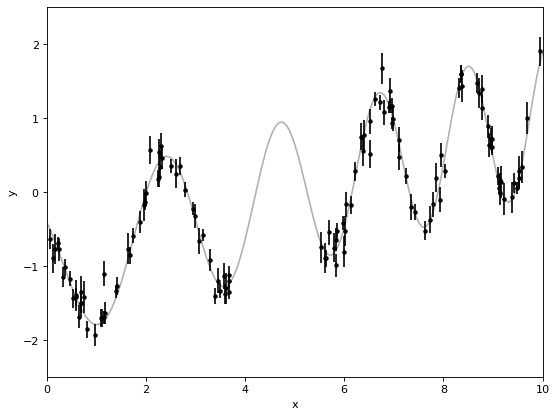

In [ ]:
# lets simulate the data
# this is taken from the tutorial
import numpy as np
np.random.seed(42)
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
print('number of points: '+str(len(t)))
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)


plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

In [ ]:
theta_init = {
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(1.0),
    "log_sigma": np.log(4.3),
    "log_alpha": np.log([1.0, 1.2]),
    "log_beta": np.log([1.2])
}

def create_alt_theta_init(theta_init):

    alt_theta_init = {
        "log_per_amp": np.random.normal(np.exp(theta_init['log_per_amp']),
                                        np.exp(theta_init['log_per_amp'])),
        "log_scale": np.random.normal(np.exp(theta_init['log_scale']),
                                        np.exp(theta_init['log_scale'])),
        "log_sigma": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma'])),
        "log_alpha": np.random.normal(np.exp(theta_init['log_alpha']),
                                        np.exp(theta_init['log_alpha'])),
        "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma']))])}
    
    return alt_theta_init


# 1. combination of carma and periodic
def build_gp(theta, t):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    per_amp = jnp.exp(theta["log_per_amp"])
    
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
    
    periodic_kernel = (
        per_amp
        * quasisep.Cosine(
            scale=jnp.exp(theta["log_scale"]),
            sigma=jnp.exp(theta["log_sigma"]),
        )
    )
    
    kernel = carma_kernel + periodic_kernel
    
    return GaussianProcess(kernel, t, diag=yerr, mean=0.0)

# 2. create loss function
@jax.jit
def neg_log_likelihood(theta, t, y):
    gp = build_gp(theta, t)
    return -gp.log_probability(y)

# 3. evaluate in situ
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

NameError: name 't' is not defined

In [ ]:
# 4. optimize
with suppress_stdout_stderr():
    solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
    soln = solver.run(theta_init, t=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:877: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_left = jnp.zeros(p, dtype=jnp.complex128)
/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:878: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_right = jnp.zeros(p, dtype=jnp.complex128)


Final negative log likelihood: 58.87323760986328


In [8]:
# print parameters
soln.params

{'log_alpha': DeviceArray([ 0.09701765, -0.03933752], dtype=float32),
 'log_beta': DeviceArray([1.1519622], dtype=float32),
 'log_per_amp': DeviceArray(1.7701517, dtype=float32),
 'log_scale': DeviceArray(0.13807052, dtype=float32),
 'log_sigma': DeviceArray(1.4159344, dtype=float32)}

In [9]:
# loop to find best value from many init

list_fun_val = []
for i in range(1000):
    alt_theta_init = create_alt_theta_init(theta_init)
    soln = solver.run(alt_theta_init, t=t, y=y)
    list_fun_val.append([soln.state.fun_val.item(),soln.params])
    # print(f"Final negative log likelihood: {soln.state.fun_val}")
    
arr_fun_val = np.array(list_fun_val)

best_fun_val = np.min(arr_fun_val[:,0])
best_par = arr_fun_val[arr_fun_val[:,0] == best_fun_val][0][1]

# 4. optimize again from the best res 
with suppress_stdout_stderr():
    solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
    soln = solver.run(best_par, t=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

/tmp/ipykernel_108024/3037893470.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_108024/3037893470.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_108024/3037893470.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_108024/3037893470.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_108024/3037893470.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_108024/3037893470.py:20: RuntimeWarning: invalid value encountered in log
  "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
/tmp/ipykernel_108024/3037893470.p

Final negative log likelihood: 36.13897705078125


/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:877: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_left = jnp.zeros(p, dtype=jnp.complex128)
/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:878: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_right = jnp.zeros(p, dtype=jnp.complex128)


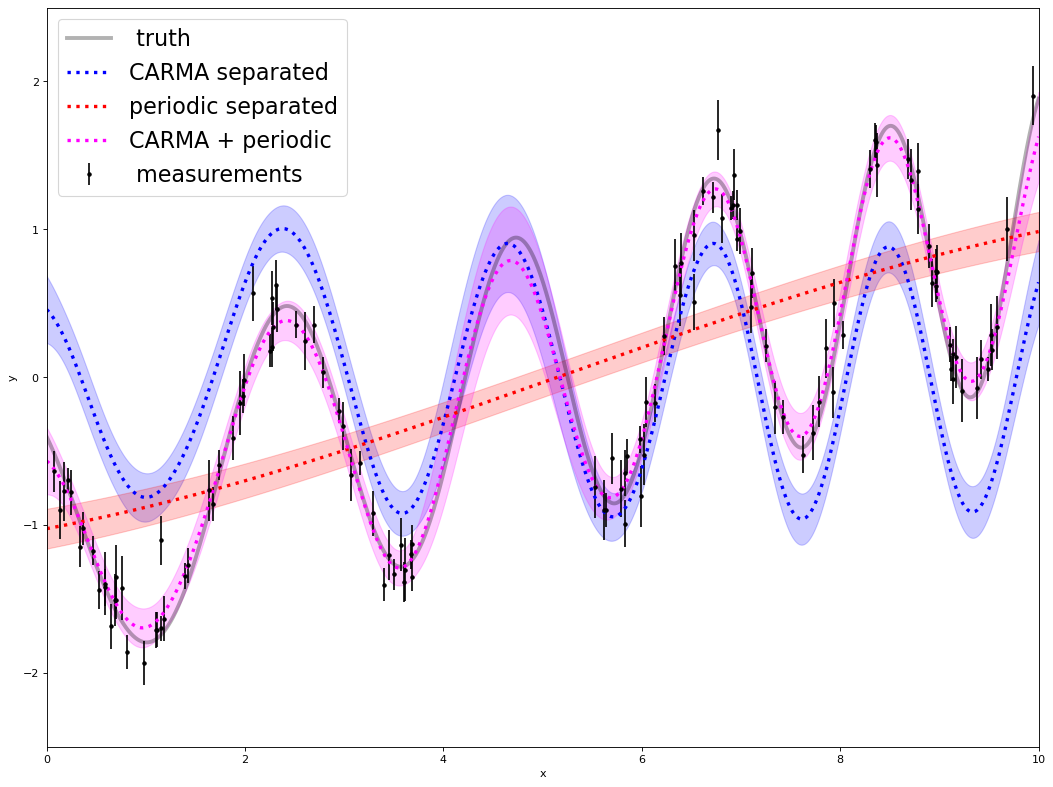

In [10]:
# define grin over which to evaluate
x = np.linspace(0, 10, 2000)

with suppress_stdout_stderr():
    gp = build_gp(soln.params, t)
    cond_gp = gp.condition(y, x).gp
    mu, var = cond_gp.loc, cond_gp.variance

    mu_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.loc
    var_carma = gp.condition(y, x, kernel=gp.kernel.kernel1).gp.variance

    mu_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.loc
    var_periodic = gp.condition(y, x, kernel=gp.kernel.kernel2).gp.variance


plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(true_t, true_y, "k", lw=3.5, alpha=0.3, label = ' truth')
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label = ' measurements')

plt.plot(x, mu_carma, color="blue", ls=':',lw=3, label = 'CARMA separated')
plt.plot(x, mu_periodic, color="red", ls=':', lw=3, label = 'periodic separated')

plt.fill_between(x, mu_carma + np.sqrt(var_carma),
                 mu_carma- np.sqrt(var_carma), color="blue", alpha=0.2)
plt.fill_between(x, mu_periodic + np.sqrt(var_periodic),
                 mu_periodic - np.sqrt(var_periodic), color="red", alpha=0.2)

plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="magenta", alpha=0.2)
plt.plot(x, mu, color="magenta", lw=3, ls=':', label = 'CARMA + periodic')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);
plt.legend(fontsize = 20)

# lsstseries case 

In [7]:
from lsstseries import Ensemble
from lsstseries.analysis.structurefunction2 import calc_sf2
from lsstseries.analysis.stetsonj import calc_stetson_J
import numpy as np
# import hipscat
import dask.dataframe as dd
import pandas as pd
from dask.distributed import Client
import multiprocessing;multiprocessing.cpu_count()

96

In [8]:
ens = Ensemble()
ens = ens.from_parquet("/data/epyc/users/brantd/timeseries/ztf_testdata/8*.parquet",
                      id_col="ps1_objid",
                      time_col="mjd",
                      flux_col="mag",
                      err_col="magerr")

ens.dropna(1).prune(100)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:43139
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35049'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44361'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37883'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42486'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37464'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:32943'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42775'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46651'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34245'
INFO:distributed.nanny:        St

In [9]:
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43139,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:34659,Total threads: 8
Dashboard: http://127.0.0.1:43604/status,Memory: 83.97 GiB
Nanny: tcp://127.0.0.1:35049,


In [10]:
# 1. combination of carma and periodic
def build_gp(theta, t):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    per_amp = jnp.exp(theta["log_per_amp"])
    
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
    
    periodic_kernel = (
        per_amp
        * quasisep.Cosine(
            scale=jnp.exp(theta["log_scale"]),
            sigma=jnp.exp(theta["log_sigma"]),
        )
    )
    
    kernel = carma_kernel + periodic_kernel
    
    return GaussianProcess(kernel, t, diag=yerr, mean=0.0)

# 2. create loss function
@jax.jit
def neg_log_likelihood(theta, t, y):
    gp = build_gp(theta, t)
    return -gp.log_probability(y)

# 3. evaluate in situ
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

In [11]:
# get any id
test_id = ens.head(1).index.values[0]
# create test timeseries
test_ts = ens.to_timeseries(test_id)
# the values need to be sorted in time
test_ts.data = test_ts.data.sort_values('mjd')
# get only one band
test_ts_r = test_ts.data[test_ts.data.index.get_level_values(0)=='r']


In [12]:
test_ts_r

mjd        mag    magerr band  num_obs
band index                                                
r    41     58369.50313  19.296867  0.074385    r      205
     42     58372.50346  19.291056  0.074073    r      205
     43     58375.50273  19.277573  0.073356    r      205
     44     58423.36147  19.339596  0.076707    r      205
     45     58423.36239  19.248087  0.071808    r      205
...                 ...        ...       ...  ...      ...
     136    59532.35993  19.555511  0.089389    r      205
     137    59537.37403  19.413792  0.080888    r      205
     138    59622.19209  19.484486  0.085045    r      205
     139    59624.17312  19.652134  0.095557    r      205
     140    59627.14932  19.476368  0.084560    r      205

[141 rows x 5 columns]

<ErrorbarContainer object of 3 artists>

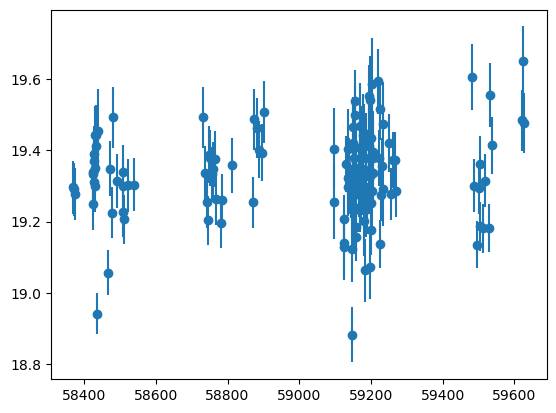

In [13]:
plt.errorbar(test_ts_r['mjd'].values, test_ts_r['mag'].values, yerr =  test_ts_r['magerr'].values, fmt="o")

In [14]:
theta_init = {
    "log_per_amp": np.log(6.0),
    "log_scale": np.log(1.0),
    "log_sigma": np.log(4.3),
    "log_alpha": np.log([1.0, 1.2]),
    "log_beta": np.log([1.2])
}

def create_alt_theta_init(theta_init):

    alt_theta_init = {
        "log_per_amp": np.random.normal(np.exp(theta_init['log_per_amp']),
                                        np.exp(theta_init['log_per_amp'])),
        "log_scale": np.random.normal(np.exp(theta_init['log_scale']),
                                        np.exp(theta_init['log_scale'])),
        "log_sigma": np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma'])),
        "log_alpha": np.random.normal(np.exp(theta_init['log_alpha']),
                                        np.exp(theta_init['log_alpha'])),
        "log_beta": np.log([np.random.normal(np.exp(theta_init['log_sigma']),
                                        np.exp(theta_init['log_sigma']))])}
    
    return alt_theta_init


# 1. combination of carma and periodic
def build_gp(theta, t, yerr):
    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    per_amp = jnp.exp(theta["log_per_amp"])
    
    carma_kernel = quasisep.CARMA.init(
        alpha=jnp.exp(theta["log_alpha"]), beta=jnp.exp(theta["log_beta"])
    )
    
    periodic_kernel = (
        per_amp
        * quasisep.Cosine(
            scale=jnp.exp(theta["log_scale"]),
            sigma=jnp.exp(theta["log_sigma"]),
        )
    )
    
    kernel = carma_kernel + periodic_kernel
    
    return GaussianProcess(kernel, t, diag=yerr, mean=0.0)

# 2. create loss function
@jax.jit
def neg_log_likelihood(theta, t, y, yerr):
    gp = build_gp(theta, t, yerr)
    return -gp.log_probability(y)

# 3. evaluate in situ
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

In [15]:
print(f"Initial negative log likelihood: {obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)[0]}")

print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)[1]}")


Initial negative log likelihood: 2923.169802257817
Gradient of the negative log likelihood, wrt the parameters:
{'log_alpha': DeviceArray([2155.2067498 , 1692.40265397], dtype=float64), 'log_beta': DeviceArray([-4346.45935547], dtype=float64), 'log_per_amp': DeviceArray(-1.40548473, dtype=float64), 'log_scale': DeviceArray(9605035.96452644, dtype=float64), 'log_sigma': DeviceArray(-2.81096947, dtype=float64)}


In [16]:
# timing
%time obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)
%time obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)
%time obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)
%timeit obj(theta_init, test_ts_r['mjd'].values, test_ts_r['mag'].values, test_ts_r['magerr'].values)

CPU times: user 3.29 ms, sys: 1.88 ms, total: 5.17 ms
Wall time: 3.35 ms
CPU times: user 1.8 ms, sys: 788 µs, total: 2.59 ms
Wall time: 2.16 ms
CPU times: user 1.76 ms, sys: 966 µs, total: 2.73 ms
Wall time: 1.94 ms
1.58 ms ± 81 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
test_id = ens.head(1).index.values[0]
test_ts = ens.to_timeseries(test_id)

# separation into 1d arrays
mjd = test_ts.data['mjd'].values
mag = test_ts.data['mag'].values
magerr = test_ts.data['magerr'].values
band = test_ts.data.index.get_level_values(0)


In [27]:
# repartition a single parquet file in order to get less lightcurves
ens = Ensemble()
ens = ens.from_parquet("/data/epyc/users/brantd/timeseries/ztf_testdata/82570690005091358.parquet",
                      id_col="ps1_objid",
                      time_col="mjd",
                      flux_col="mag",
                      err_col="magerr")
ens._data = ens._data.repartition(partition_size='100KB').partitions[0:10]
ens.dropna(1).prune(5)

/astro/users/ncaplar/miniconda3/envs/tiny_lsst/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36533 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33446
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:36533
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46637'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33492'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46168'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:32886'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36988'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44891'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45851'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39599'
INFO:

In [28]:
ens_comp = ens._data.compute()

In [29]:
# number of observations
# 118162 obs took 12 min with 10 worksers
# 11919 obs took 5.20 min with 10 worksers 
len(ens_comp)

11919

In [30]:
# number of lightcurves
len(np.unique(ens_comp.index))

145

In [31]:
# defining a function that can work with batch
def test_ts_obj(mjd, mag, magerr, band):

    # in which band was the observation taken
    band = band.values

    # hard coded that you analyze g-band
    mjd = mjd.values[band == 'g']
    mag = mag.values[band == 'g']
    magerr = magerr.values[band == 'g']
    if len(mjd) == 0:
        return 999

    # you need to sort the data to be in chronological order 
    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]
    
    res = obj(theta_init, mjd, mag, magerr)[0]    
    return res 

In [32]:
res_test = ens.batch(test_ts_obj, None, True, 'mjd', 'mag', 'magerr', 'band')

/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:877: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_left = jnp.zeros(p, dtype=jnp.complex128)
/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:878: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  num_right = jnp.zeros(p, dtype=jnp.complex128)
/astro/users/ncaplar/github/tinygp_carma/tinygp/src/tinygp/kernels/quasisep.py:87

In [26]:
type(res_test)

pandas.core.series.Series

# Run one by one 

In [47]:
import tqdm
from tqdm import tqdm

In [48]:
uniq_id = np.unique(ens_comp.index)

res_man = []
for i in tqdm(range(len(uniq_id))):

    mjd = ens_comp[ens_comp.index == uniq_id[i]]['mjd'].values
    mag = ens_comp[ens_comp.index == uniq_id[i]]['mag'].values
    magerr = ens_comp[ens_comp.index == uniq_id[i]]['magerr'].values

    sort_arr = np.argsort(mjd)
    mjd = mjd[sort_arr]
    mag = mag[sort_arr]
    magerr = magerr[sort_arr]

    res_man.append(obj(theta_init, mjd, mag, magerr)[0])

  0%|          | 0/145 [00:00<?, ?it/s]

In [40]:
ens_comp[ens_comp.index == uniq_id[0]]

,mjd,mag,magerr,band,num_obs
ps1_objid,,,,,
82570690170984496,58378.48179,20.489401,0.213363,g,12
82570690170984496,58383.48220,21.154053,0.272851,g,12
82570690170984496,58425.37711,20.925426,0.252241,g,12
82570690170984496,58426.39686,21.221550,0.278936,g,12
82570690170984496,58429.42474,21.477474,0.302007,g,12
82570690170984496,59143.40076,21.127140,0.270425,g,12
82570690170984496,59145.40196,21.273815,0.283648,g,12
82570690170984496,59193.33366,20.949358,0.254398,g,12
82570690170984496,59257.14877,21.150063,0.272491,g,12
